## Set up

In [1]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)



print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-dtuaamyp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-dtuaamyp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


/home/student/miniconda3/envs/YT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 1.8.0
Torchvision version: 0.9.0
CUDA is available: True


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

## Loading Image

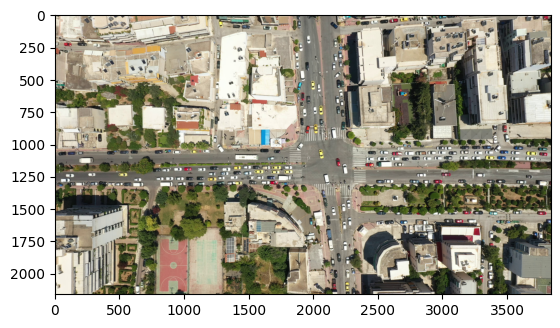

In [3]:
Image_PATH = "./dataset/Galatsi/"
image = cv2.imread(Image_PATH + 'frame_0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.axis('on')
plt.show()

## Extract reference points from Vehicle Detection

In [4]:
from geopy.distance import distance
import matplotlib.pyplot as plt
import numpy as np
import os



import mmcv
from mmcv import collect_env, Config
from mmcv.ops import nms_rotated
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, set_random_seed, show_result_pyplot, train_detector
from mmdet.datasets import build_dataset
from mmdet.datasets.custom import CustomDataset
from mmdet.models import build_detector

from mmrotate import evaluation
from mmrotate.apis import inference_detector_by_patches
from mmrotate.core import obb2poly_np, poly2obb_np
from mmrotate.core.evaluation import eval_rbbox_map
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset

#from CustomSuperGlue import *
#from CustomSIFT import *

In [5]:
# Filter output of MMROTATE's Oriented RCNN result of type [[c1 rbbox], [c2 rbbox], ....]
# selection only a subset of results
# Ex) [[small-vehicle rbbox], [large-vehicle rbbox]]
def result_filtering_class(result, classes, subclasses, shrink=False):
    if shrink:
        out = [result[classes.index(c)] for c in subclasses]
    else:
        out = [result[classes.index(c)] if c in subclasses else np.array([]).reshape((0, 6)) for c in classes]
    
    return out


def result_filtering_score(result, score):
    filtered = []
    for result_c in result:
        if len(result_c) == 0:
            filtered.append(np.array([]).reshape((0, 6)))
        else:
            tmp = [r for r in result_c if r[-1]>=score]
            if len(tmp)>0:
                filtered.append(np.array(tmp))
            else:
                filtered.append(np.array([]).reshape((0, 6)))
    
    return filtered


def result_filtering(result, score, classes, subclasses):
    result_f1 = result_filtering_class(result, classes, subclasses)
    result_f2 = result_filtering_score(result_f1, score)
    
    return result_f2

def from_rbbox_to_4pts(bbox):
    """Convert oriented bounding boxes to polygons.
    Args:
        obbs (ndarray): [x_ctr,y_ctr,w,h,angle]
    Returns:
        polys (ndarray): [x0,y0,x1,y1,x2,y2,x3,y3]
    """
    xc, yc, w, h, ag = bbox[:5]
    wx, wy = w / 2 * np.cos(ag), w / 2 * np.sin(ag)
    hx, hy = -h / 2 * np.sin(ag), h / 2 * np.cos(ag)
    p1 = (xc - wx - hx, yc - wy - hy)
    p2 = (xc + wx - hx, yc + wy - hy)
    p3 = (xc + wx + hx, yc + wy + hy)
    p4 = (xc - wx + hx, yc - wy + hy)
    poly = np.int0(np.array([p1, p2, p3, p4]))
        
    return poly, bbox[-1]

def from_4pts_to_rbbox(pts):
    """Convert polygons to oriented bounding boxes.
    Args:
        polys (ndarray): [x0,y0,x1,y1,x2,y2,x3,y3]
    Returns:
        obbs (ndarray): [x_ctr,y_ctr,w,h,angle]
    Test:
        from_rbbox_to_4pts(from_4pts_to_rbbox(list(map(int, ['881', '332', '918', '317', '926', '335', '889', '351']))))
    """
    bboxps = np.array(pts).reshape((4, 2))
    rbbox = cv2.minAreaRect(bboxps)
    x, y, w, h, a = rbbox[0][0], rbbox[0][1], rbbox[1][0], rbbox[1][1], rbbox[2]
    if w < 2 or h < 2:
        return
    while not 0 < a <= 90:
        if a == -90:
            a += 180
        else:
            a += 90
            w, h = h, w
    a = a / 180 * np.pi
    assert 0 < a <= np.pi / 2
    
    return x, y, w, h, a

def show_image_inline(img, trans_level=1, figsize=None, axis_off=False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if figsize:
        plt.figure(figsize=figsize)
    plt.imshow(img, alpha=trans_level)
    if axis_off:
        plt.axis('off')

    plt.show(block=False)
        
    return

In [7]:
# Choose to use a config and initialize the detector
config = '../mmrotate/configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = '../mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
for k in config.keys():
    print("=====================")
    print(k)
    print(config[k])
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: ../mmrotate/checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
dataset_type
DOTADataset
data_root
data/split_1024_dota1_0/
img_norm_cfg
{'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}
train_pipeline
[{'type': 'LoadImageFromFile'}, {'type': 'LoadAnnotations', 'with_bbox': True}, {'type': 'RResize', 'img_scale': (1024, 1024)}, {'type': 'RRandomFlip', 'flip_ratio': [0.25, 0.25, 0.25], 'direction': ['horizontal', 'vertical', 'diagonal'], 'version': 'le90'}, {'type': 'Normalize', 'mean': [123.675, 116.28, 103.53], 'std': [58.395, 57.12, 57.375], 'to_rgb': True}, {'type': 'Pad', 'size_divisor': 32}, {'type': 'DefaultFormatBundle'}, {'type': 'Collect', 'keys': ['img', 'gt_bboxes', 'gt_labels']}]
test_pipeline
[{'type': 'LoadImageFromFile'}, {'type': 'MultiScaleFlipAug', 'img_scale': (1024, 1024), 'flip': False, 'transforms': [{'type': 'RResize'}, {'type': 'Normalize', 'mean': [123.675, 116.28, 103.53], 'std': [58.39

OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [8]:
def process_image(image_path, output_dir, model):
    img = cv2.imread(image_path)
    result = inference_detector_by_patches(model, img, [1300], [200], [1.0], 0.1) # size of patch and steps for single frame
    result = result_filtering(result, 0.5, model.CLASSES, subclasses=["small-vehicle", "large-vehicle"])

    # Generate output file path
    base_name = os.path.basename(image_path)
    output_file = os.path.join(output_dir, f"{os.path.splitext(base_name)[0]}.txt")
    
    with open(output_file, "w") as f:
        for c in ["small-vehicle", "large-vehicle"]:
            for r in result[list(model.CLASSES).index(c)]:
                bb_pts, prob = from_rbbox_to_4pts(r)
                x1, y1, x2, y2, x3, y3, x4, y4 = bb_pts.flatten()
                f.write("{},{},{},{},{},{},{},{},{},{}\n".format(x1, y1, x2, y2, x3, y3, x4, y4, c, prob))

In [9]:
# Directory of images
input_dir = "./dataset/Galatsi/"
# Directory to save the results
output_dir = "./Vehicle_Detection/"
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List of all images
image_files = [f for f in os.listdir(input_dir) if f.endswith(".jpg")] # all images are .jpg

# Loop through all images in the input directory with a progress bar
for image_file in tqdm(image_files, desc="Processing Images"):
    image_path = os.path.join(input_dir, image_file)
    process_image(image_path, output_dir, model)

print("Processing complete.")

Processing Images:   0%|          | 0/1504 [00:00<?, ?it/s]

/tmp/ipykernel_3136642/74345377.py:48: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  poly = np.int0(np.array([p1, p2, p3, p4]))
Processing Images: 100%|██████████| 1504/1504 [2:45:04<00:00,  6.59s/it] 

Processing complete.


## Load Vehicle Mask

In [10]:
# Path to the results file
file_path = './Vehicle_Detection/frame_0.txt'

# Initialize an empty list to store all the coordinates
coordinates_list = []

# Read the file
with open(file_path, 'r') as file:
    for line in file:
        # Split the line into components
        components = line.strip().split(',')
        # Extract the coordinate points and convert them to float
        coords = list(map(float, components[:8]))
        # Append the coordinates to the list
        coordinates_list.append(coords)

# Convert the list of coordinates into a PyTorch tensor
boxes = torch.tensor(coordinates_list)

In [11]:
def create_vehicle_mask(bounding_boxes, image_shape):
    # Create a blank binary mask with the same dimensions as the image
    vehicle_mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Iterate through each bounding box
    for box in bounding_boxes:
        # Extract the corners
        pts = np.array([[box[0], box[1]],
                        [box[2], box[3]],
                        [box[4], box[5]],
                        [box[6], box[7]]], np.int32)

        # Reshape pts to a 3D array for cv2.fillPoly
        pts = pts.reshape((-1, 1, 2))

        # Draw the polygon on the mask
        cv2.fillPoly(vehicle_mask, [pts], 1)

    return vehicle_mask

In [12]:
vehicle_mask = create_vehicle_mask(boxes, np.array(image).shape[0:2])

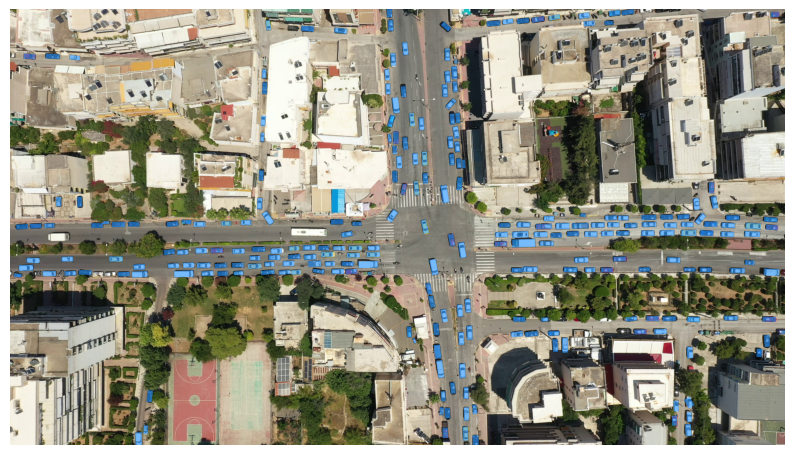

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(vehicle_mask, plt.gca())
plt.axis('off')
plt.show()

## Load the model and predictor

In [14]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

# sam_ft_ckpt = "/content/drive/MyDrive/Road Segmentation/sam_model_b.pth"
sam_ft_ckpt = "./models/sam_model_h.pth"
# model_type = "vit_b"
model_type = "vit_h"

device = "cuda"

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

sam_ft = sam_model_registry[model_type](checkpoint=sam_ft_ckpt)
sam_ft.to(device=device)

predictor = SamPredictor(sam_ft)

In [15]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_ckpt_h = "./models/sam_model_h.pth"
sam_ckpt_b = "./models/sam_model_b.pth"
model_type_h = "vit_h"
model_type_b = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type_h](checkpoint=sam_ckpt_h)
sam_b = sam_model_registry[model_type_b](checkpoint=sam_ckpt_b)

# sam.to(device=device)
sam_b.to(device=device)

predictor = SamPredictor(sam)
predictor_b = SamPredictor(sam_b)

## Predict the mask

In [16]:
image_cv = np.array(image)
predictor.set_image(image_cv)

In [17]:
sam_masks, _, _ = predictor.predict(
    point_coords=None, 
    point_labels=None, 
    multimask_output=False,
)


In [21]:
# Model vit_b
predictor_b.set_image(image_cv)

sam_masks_b, _, _ = predictor_b.predict(
    point_coords=None, 
    point_labels=None, 
    multimask_output=False,
)

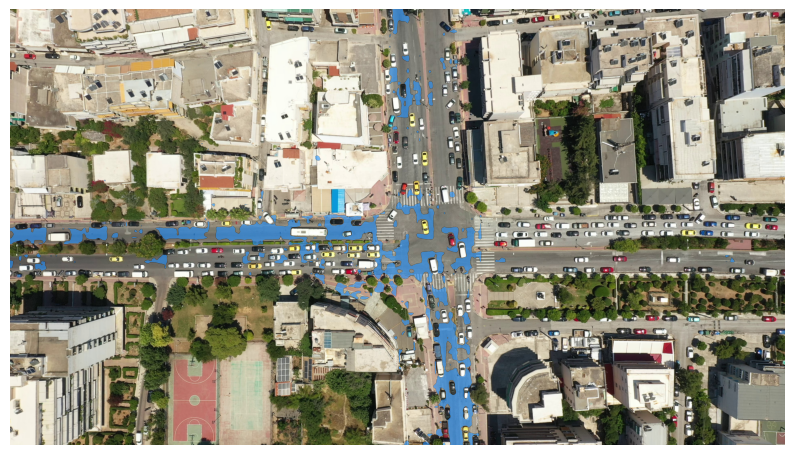

In [24]:
seg_mask_b = sam_masks_b #+vehicle_mask
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(seg_mask_b, plt.gca())
plt.axis('off')
plt.show()

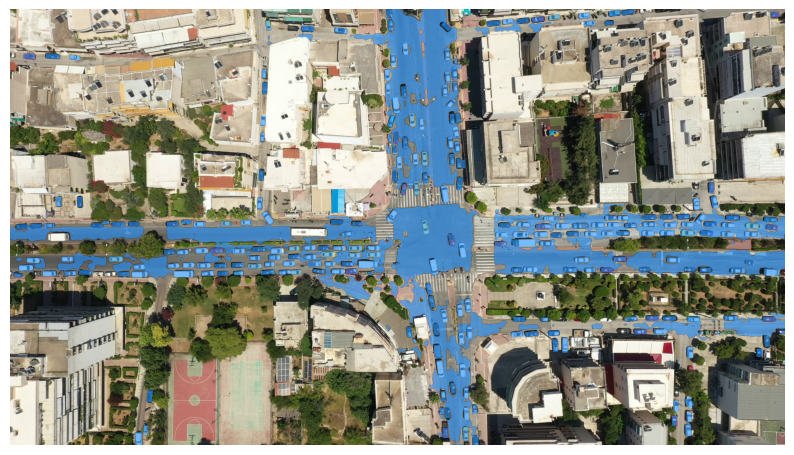

In [26]:
seg_mask = sam_masks + vehicle_mask
seg_mask[seg_mask == 2] = 1
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(seg_mask, plt.gca())
plt.axis('off')
plt.show()

## Post Processing

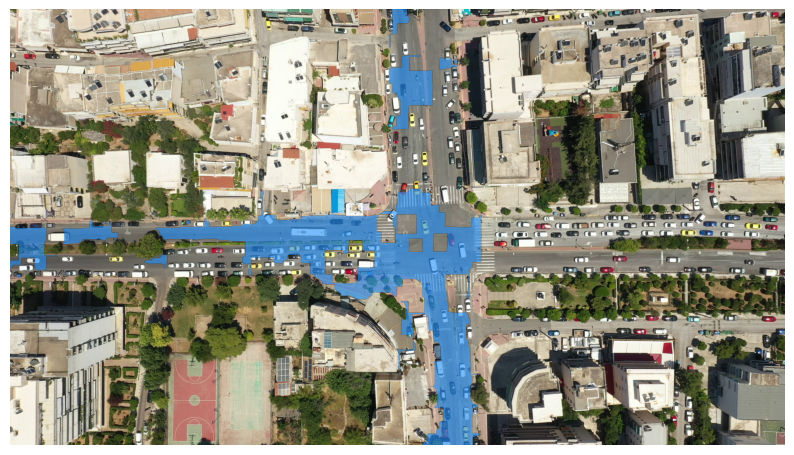

In [25]:
# Model vit_b
from skimage import measure, morphology

# Ensure the mask is a uint8 type
sam_connect_mask_b = seg_mask_b.astype(np.uint8)

# Denoising the mask using morphological operations
kernel = np.ones((5, 5), np.uint8)  # kernel for morphological operations
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
# eroded_mask = cv2.erode(sam_connect_mask.squeeze(), kernel, iterations=1)  # Erosion to remove noise
# dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=8)  # Dilation to restore eroded parts of the mask

# Perform morphological closing to connect regions
closed_mask_b = cv2.morphologyEx(sam_connect_mask_b.squeeze(), cv2.MORPH_CLOSE, kernel, iterations=16)


# Connected Component Labeling
labeled_mask_b, num_labels_b = measure.label(closed_mask_b, return_num=True, background=0)
label_props_b = measure.regionprops(labeled_mask_b)

# Filter connected components based on area
area_threshold = 3000  # Set area threshold
filtered_mask_b = np.zeros_like(labeled_mask_b)
for prop in label_props_b:
    if prop.area > area_threshold:
        filtered_mask_b[labeled_mask_b == prop.label] = 1

# Reshape the filtered mask to maintain the original shape (1, height, width)
sam_connect_mask_b = filtered_mask_b[np.newaxis, ...]

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(sam_connect_mask_b, plt.gca())
plt.axis('off')
plt.show()

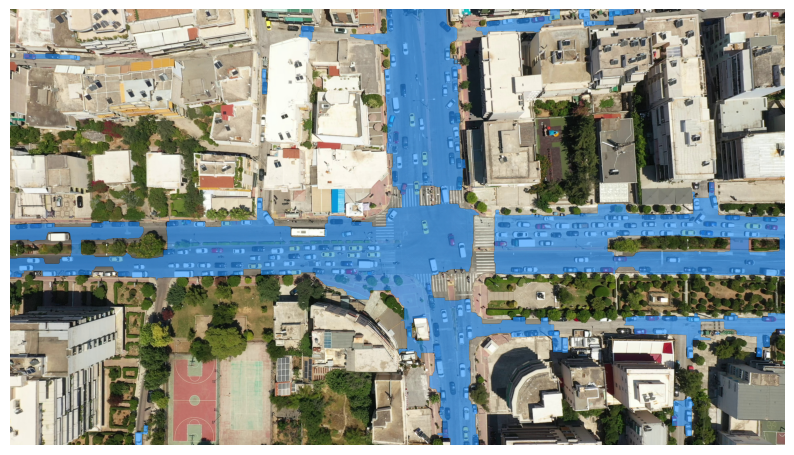

In [28]:
from skimage import measure, morphology

# Ensure the mask is a uint8 type
sam_connect_mask = seg_mask.astype(np.uint8)

# Denoising the mask using morphological operations
kernel = np.ones((5, 5), np.uint8)  # kernel for morphological operations
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
# eroded_mask = cv2.erode(sam_connect_mask.squeeze(), kernel, iterations=1)  # Erosion to remove noise
# dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=8)  # Dilation to restore eroded parts of the mask

# Perform morphological closing to connect regions
closed_mask = cv2.morphologyEx(sam_connect_mask.squeeze(), cv2.MORPH_CLOSE, kernel, iterations=16)


# Connected Component Labeling
labeled_mask, num_labels = measure.label(closed_mask, return_num=True, background=0)
label_props = measure.regionprops(labeled_mask)

# Filter connected components based on area
area_threshold = 3000  # Set area threshold
filtered_mask = np.zeros_like(labeled_mask)
for prop in label_props:
    if prop.area > area_threshold:
        filtered_mask[labeled_mask == prop.label] = 1

# Reshape the filtered mask to maintain the original shape (1, height, width)
sam_connect_mask = filtered_mask[np.newaxis, ...]

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(sam_connect_mask, plt.gca())
plt.axis('off')
plt.show()